In [2]:
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.utils import to_categorical

# from tensorflow.keras.metrics import BinaryAccuracy,FalsePositives,FalseNegatives,TruePositives,TrueNegatives,Precision,
import os
import time
import gc
import copy



In [3]:
electron_path = '/kaggle/input/electron-photon-classifier/electron/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
photon_path = '/kaggle/input/electron-photon-classifier/photon/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'

electron = h5py.File(electron_path, "r")
print([x for x in electron])
print(electron['X'],"\n",electron['y'])
print(electron['X'][0].shape)
print((electron['y'][:]))
photon = h5py.File(photon_path, "r")
print([x for x in photon])
print(photon['X'],"\n",photon['y'])
print(photon['X'][0].shape)
print((photon['y'][:]))

['X', 'y']
<HDF5 dataset "X": shape (249000, 32, 32, 2), type "<f4"> 
 <HDF5 dataset "y": shape (249000,), type "<f4">
(32, 32, 2)
[1. 1. 1. ... 1. 1. 1.]
['X', 'y']
<HDF5 dataset "X": shape (249000, 32, 32, 2), type "<f4"> 
 <HDF5 dataset "y": shape (249000,), type "<f4">
(32, 32, 2)
[0. 0. 0. ... 0. 0. 0.]


In [4]:
def plot_pics(num,cmapclr,cmapclr_):
    el1 = electron['X'][num][:,:,0]
    el2 = electron['X'][num][:,:,1]

    ph1 = photon['X'][num][:,:,0]
    ph2 = photon['X'][num][:,:,1]

    plt.figure(figsize = (16,16))
    
    plt.subplot(1,4,1)
    plt.title('Hit energy e-')
    plt.imshow(el1, cmap=cmapclr, alpha=1)
    plt.subplot(1,4,2)
    plt.title("Time e-")
    plt.imshow(el2, cmap = cmapclr_, alpha=1)

    plt.subplot(1,4,3)
    plt.title('Hit energy ph')
    plt.imshow(ph1, cmap = cmapclr, alpha=1)
    plt.subplot(1,4,4)
    plt.title("Time ph")
    plt.imshow(ph2, cmap = cmapclr_, alpha=1)

xy = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']

print(len(xy))


166


In [4]:
print(type(electron['X'][0]))

<class 'numpy.ndarray'>


In [5]:
def plotV2(arr,x,cmapclr,cmapclr_):
    image_ch1 = np.array((arr)[x])[:,:,0]
    image_ch2 = np.array((arr)[x])[:,:,1]
    plt.figure(figsize = (16,16))
    plt.subplot(1,2,1)
    plt.title('Hit energy e-')
    plt.imshow(image_ch1, cmap=cmapclr, alpha=1)
    plt.subplot(1,2,2)
    plt.title("Time e-")
    plt.imshow(image_ch2, cmap = cmapclr_, alpha=1)
# plotV2(trainnn,12,'gray_r','gray_r')
# plotV2(train,12,'gray_r','gray_r')


In [ ]:
print(electron['X'][0].shape)
x = random.randint(0,248900)
# k = 56
print(x)
for i in range(10):
    
    plot_pics(x+i,'gray_r','gray_r')
#plot_pics(X+1,'gray_r','rainbow')

In [ ]:
x = random.randint(0,20)

plotV2(trainnn,x,'gray_r','rainbow')
plotV2(train,x,'gray_r','rainbow')


In [6]:
# del electron_Array, photon_Array
gc.collect()

98

In [ ]:
# emp = []
# emp = copy.deepcopy(electron['X'][:])
print(len(emp),np.array(emp).shape,np.array(electron_Array,dtype = object).shape)

## USE zip lmaoo

In [7]:
electron_arre = copy.deepcopy(electron['X'][:])
photon_arre = copy.deepcopy(photon['X'][:])
both = []
both.extend(electron_arre)
both.extend(photon_arre)

In [8]:
electron_arrere = copy.deepcopy(electron['y'][:])
photon_arrere = copy.deepcopy(photon['y'][:])
both_re = []
both_re.extend(electron_arrere)
both_re.extend(photon_arrere)

In [9]:
both = np.array(both)
both_re = np.array(both_re)
print(both.shape,both_re.shape)

(498000, 32, 32, 2) (498000,)


In [10]:
# del train_ultimate,train
gc.collect()

92

In [11]:
train_ultimate = [x for x in zip(both,both_re)]
electron.close()
photon.close()

In [12]:
train = []
train_label = []
def shuffle_and_distributeLabelsV2():
    global train
    global train_ultimate
    global train_label
    np.random.shuffle(train_ultimate)
    train = [x[0] for x in train_ultimate]
    train_label = [x[1] for x in train_ultimate]

In [13]:
def normalise_bw_01(arr):
    arr = np.array(arr)
    arr = arr.reshape(-1)
    print(f"Before min:{np.min(arr)} max:{np.max(arr)}")
    global_min = np.min(arr)
    arr+= -global_min
    global_max = np.max(arr)
    arr/= global_max
    arr = arr.reshape(498000, 32, 32, 2)
    print(f"After min:{np.min(arr)} max:{np.max(arr)}")
    return arr

In [14]:
shuffle_and_distributeLabelsV2()
train = normalise_bw_01(train)

Before min:-2.512557029724121 max:2.2779698371887207
After min:0.0 max:1.0


In [15]:
print(both.shape,both_re.shape,np.array(train_ultimate,dtype = object).shape,len(train_ultimate),len(train),train_label[:10])

(498000, 32, 32, 2) (498000,) (498000, 2) 498000 498000 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]


In [16]:
del train_ultimate
gc.collect()

69

### Deprecated

In [ ]:
electron_Array = []
photon_Array = []
def array_allocator(start,end):
    counter = 0
    for i in range(start,end):
        temp_arr = []
        global electron_Array
        global photon_Array
        temp_arr.append(electron['X'][i])
        temp_arr.append(electron['y'][i])
        electron_Array.append(temp_arr)
        temp_arr = []
        temp_arr.append(photon['X'][i])
        temp_arr.append(photon['y'][i])
        photon_Array.append(temp_arr)
        del temp_arr
        gc.collect()
        counter += 1
        if counter % 10 == 0:
            print()
        print(counter,end=" ")


In [ ]:
# train = []
# train_label = []
# def shuffle_and_distributeLabels():
#     global train
#     global train_label
#     not_train = electron_Array+photon_Array
#     np.random.shuffle(not_train)
#     train = [x[0] for x in not_train]
#     train_label = [x[1] for x in not_train]
#     print(x.shape for x in train[:])
#     print(x.shape for x in train_label[:])
#     print(train,train_label)


In [ ]:
print(len(train),np.array(train).shape,train.shape)

In [ ]:
del trainV2
gc.collect()
trainV2 = copy.deepcopy(train)
# trainV2 = np.array(trainV2)
k = 1
for i in np.array(trainV2).shape:
    k*=i
print(k)

In [ ]:
array_allocator(0,2490)
# print(electron_Array[0])
# print(electron['X'][0])
shuffle_and_distributeLabels()
trainV2 = copy.deepcopy(train)
convert_bw_01(trainV2)

labels = {'electron':1,'photon':0}


# Plot a Max function to analyse data

In [ ]:
trainnn = []
trainnn=copy.deepcopy(train)

In [ ]:
def show_minmax4D(arr):
    g_max = 0
    g_min = 0
    for i in arr:
        c = 0
        min_num = 0
        max_num = 0
        for j in i[:,:,:]:
            for k in j:
                for l in k:
                    if l > max_num:
                        max_num = l
                    if l < min_num:
                        min_num = l
                    if l < g_min:
                        g_min = l
                    if l < g_max:
                        g_max = l
#         print('max',max_num,'min',min_num)
    print('Global min, max',g_min,g_max)

def convert_bw_01(arr): #only for 4d arrays
    s_time = time.time()
    counter = 0
    
    for i in range(len(arr)):
        small_stime = time.time()
        min_num = 0
        max_num = 0
        for j in range(len(arr[i])):
            for k in range(len(arr[i][j])):
                for l in range(len(arr[i][j][k])):
                    if arr[i][j][k][l] > max_num:
                        max_num = arr[i][j][k][l]
                    if arr[i][j][k][l] < min_num:
                        min_num = arr[i][j][k][l]
                    if min_num<0:
                        p_min_num = -min_num
                        arr[i][j][k][l] += p_min_num
                    else:
                        arr[i][j][k][l]+=min_num
        for i in range(len(arr)):
            max_num = 0
            for j in range(len(arr[i])):
                for k in range(len(arr[i][j])):
                    for l in range(len(arr[i][j][k])):
                        if arr[i][j][k][l] > max_num:
                            max_num = arr[i][j][k][l]
            arr[i]/=float(max_num)
        small_ftime = time.time()
        print('-_-')
        print(counter,'%.2f'%float(small_ftime-small_stime))
        counter+=1
    f_time = time.time()
    print('Converting values between 0-1 completed in: %.2f'%float(s_time-f_time))
    return arr

In [ ]:
trainV2 = copy.deepcopy(train)
trainV2 = np.array(trainV2[:])
# convert_bw_01(trainV2)


In [ ]:
del time

In [ ]:
e = time.time()
show_minmax4D(trainV2[:])
x = time.time()
print('%.2f'%float(x-e))

# convert_bw_01(train[:20])

# show_minmax4D(train[:20])


In [ ]:
# trainV2[0][:][:][:]
print([f"{x}" for x in trainV2[0][12][12][:]])

In [ ]:
print(len([x for x in train[:]]),len(train_label),len(electron_Array[0]))


In [17]:
sumnum = 50000
train = train[:sumnum]
train_label = train_label[:sumnum]

In [18]:
val_size = 0.2
test_size = 0.1

val_data_size = int(len(train)*val_size)
test_data_size = int(len(train)*test_size)
train_data_size = len(train)-val_data_size-test_data_size

train_data = train[:train_data_size]
train_labels = train_label[:train_data_size]

val_data = train[train_data_size:train_data_size+test_data_size]
val_labels = train_label[train_data_size:train_data_size+test_data_size]

test_data = train[train_data_size+test_data_size:]
test_labels = train_label[train_data_size+test_data_size:]

In [19]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

val_data = np.array(val_data)
val_labels = np.array(val_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [20]:
print(len(val_data),len(val_labels))
print(val_data_size,test_data_size,train_data_size,len(train))
print()
# print(train_label[train_data_size:test_data_size])

5000 5000
10000 5000 35000 50000



In [21]:
del both,both_re, photon_arrere, electron_arrere
del electron_arre,photon_arre
gc.collect()

115

In [22]:
def plot_Model_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

In [23]:
def plot_Model_accuracy():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [66]:
def plot_Model_lossAcc(his):
    plt.figure(figsize = (16,8))

    plt.subplot(2,2,1)
    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    
    plt.figure(figsize = (16,8))

    plt.subplot(2,2,2)
    plt.plot(his.history['accuracy'])
    plt.plot(his.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    


In [25]:
def plot_Model_RocAucV2():
    predicted_labels = model.predict(test_data)

    fpr, tpr, thresholds = roc_curve(test_labels, predicted_labels)
    roc_auc = roc_auc_score(test_labels, predicted_labels)

    # Plot the ROC curve for the positive class
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='green', lw=1,
             label='ROC curve (AUC = {0:0.2f})'
             ''.format(roc_auc))

    # Plot the diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    # Set the limits and labels of the plot
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve for Binary Classification')
    plt.legend(loc="lower right")
    plt.show()


In [26]:
def plot_Model_RocAuc():
    predicted_labels = model.predict(test_data)

    y_test_binary = to_categorical(test_labels)
    y_pred_binary = predicted_labels

    # Calculate the ROC curves and their AUC scores for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = y_test_binary.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_binary[:, i])
        roc_auc[i] = roc_auc_score(y_test_binary[:, i], y_pred_binary[:, i])

    # Compute micro-average ROC curve and ROC AUC score
    fpr_micro, tpr_micro, _ = roc_curve(y_test_binary.ravel(), y_pred_binary.ravel())
    roc_auc_micro = roc_auc_score(y_test_binary, y_pred_binary)

    # Plot the ROC curves for each class and the micro-average ROC curve
    plt.figure(figsize=(8,6))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    # plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=1,
    #          label='Micro-average ROC curve (AUC = {0:0.2f})'
    #          ''.format(roc_auc_micro))

    # Plot the diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    # Set the limits and labels of the plot
    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
metrics=[tf.keras.metrics.TruePositives(name= 'tp'),tf.keras.metrics.FalsePositives(name='fp'),tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalseNegatives(name='fn'),tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]
print(metrics)

[<keras.metrics.metrics.TruePositives object at 0x7f030e1e0ad0>, <keras.metrics.metrics.FalsePositives object at 0x7f03169d9d50>, <keras.metrics.metrics.TrueNegatives object at 0x7f02a7830310>, <keras.metrics.metrics.FalseNegatives object at 0x7f02a7830b90>, <keras.metrics.metrics.BinaryAccuracy object at 0x7f02a781c310>, <keras.metrics.metrics.Precision object at 0x7f02a781cd50>, <keras.metrics.metrics.Recall object at 0x7f02a643f390>, <keras.metrics.metrics.AUC object at 0x7f02a643fc10>]


In [47]:
del model
# del history
gc.collect()

51728

In [48]:
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.,seed = 121)
# layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3),strides = (1,1), padding = 'valid', activation = 'relu', input_shape = (32,32,2)))
# model.add(tf.keras.layers.Conv2D(32,(3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))
# model.add(tf.keras.layers.Conv2D(64,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(12,(3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(64, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(64, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(64, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))
model.add(tf.keras.layers.Conv2D(8,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))

model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(1024,activation = 'relu'))
# model.add(tf.keras.layers.Dense(256,activation = 'relu'))

# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation = 'relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
# model.add(tf.keras.layers.Dense(128,activation = 'relu'))

model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))


### sparse_categorical_crossentropy, binary_crossentropy

In [53]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 16)        304       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 12)        1740      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 12)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 8)           872       
                                                                 
 flatten_4 (Flatten)         (None, 128)              

In [54]:
checkpoint_filepath = '/kaggle/working/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy')
def scheduler(epoch, lr):
    flr = lr
    if epoch < 10 :
        return lr
    elif epoch > 10 and epoch <25:
        return flr * tf.math.exp(0.01)
    else:
        return lr * tf.math.exp(-0.01)
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [55]:
history = model.fit(train_data,train_labels,epochs=100,batch_size = 500,callbacks=[model_checkpoint_callback,learning_rate_callback],validation_data=(val_data,val_labels),shuffle=True)

Epoch 1/100
70/70 [==============================] - 4s 27ms/step - loss: 0.6556 - accuracy: 0.6156 - val_loss: 0.6528 - val_accuracy: 0.6132 - lr: 0.0010
Epoch 2/100
70/70 [==============================] - 62s 892ms/step - loss: 0.6561 - accuracy: 0.6143 - val_loss: 0.6517 - val_accuracy: 0.6196 - lr: 0.0010
Epoch 3/100
70/70 [==============================] - 2s 28ms/step - loss: 0.6549 - accuracy: 0.6156 - val_loss: 0.6528 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 4/100
70/70 [==============================] - 2s 26ms/step - loss: 0.6562 - accuracy: 0.6139 - val_loss: 0.6575 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 5/100
70/70 [==============================] - 2s 25ms/step - loss: 0.6552 - accuracy: 0.6159 - val_loss: 0.6511 - val_accuracy: 0.6196 - lr: 0.0010
Epoch 6/100
70/70 [==============================] - 2s 24ms/step - loss: 0.6538 - accuracy: 0.6176 - val_loss: 0.6512 - val_accuracy: 0.6176 - lr: 0.0010
Epoch 7/100
70/70 [==============================] - 2s 24ms/step - 

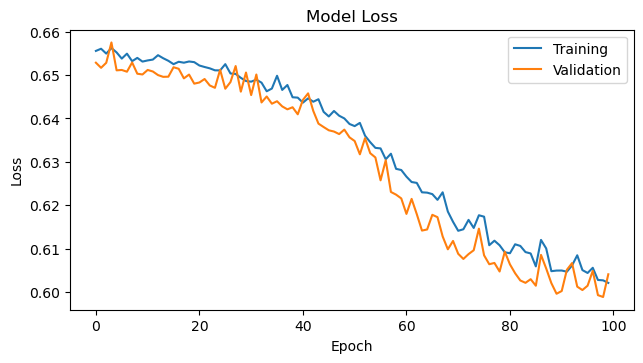

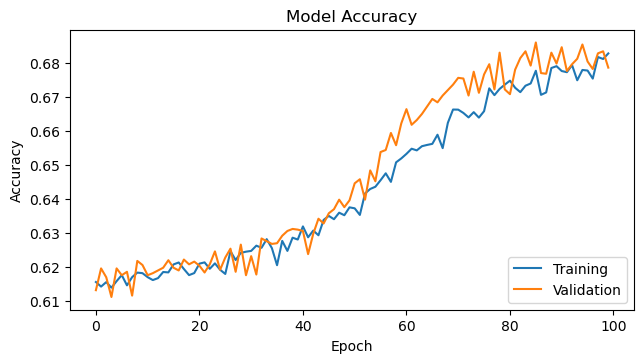

313/313 [==============================] - 1s 3ms/step


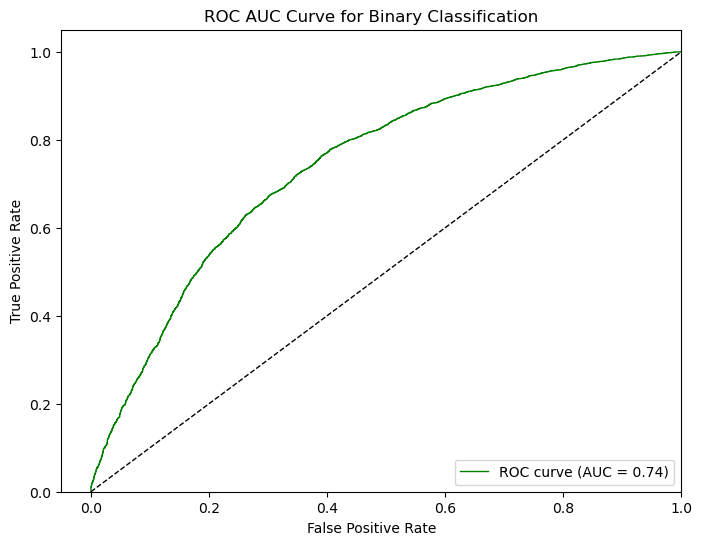

In [56]:
# plot_Model_loss()
# plot_Model_accuracy()
plot_Model_lossAcc()
plot_Model_RocAucV2()

In [58]:
model.save('/kaggle/working/model2nd',include_optimizer=True)

In [64]:
def schedulerV2(epoch, lr):
    flr = lr = 9.802e-4
    if epoch < 10 :
        return lr
#     elif epoch > 10 and epoch <25:
#         return flr * tf.math.exp(0.01)
    else:
        return lr * tf.math.exp(-0.01)
learning_rate_callbackV2 = tf.keras.callbacks.LearningRateScheduler(schedulerV2)

In [65]:
history2 = model.fit(train_data,train_labels,epochs=100,batch_size = 500,callbacks=[model_checkpoint_callback,learning_rate_callbackV2],validation_data=(val_data,val_labels),shuffle=True)

Epoch 1/100
70/70 [==============================] - 2s 26ms/step - loss: 0.5961 - accuracy: 0.6878 - val_loss: 0.5946 - val_accuracy: 0.6876 - lr: 9.8020e-04
Epoch 2/100
70/70 [==============================] - 2s 25ms/step - loss: 0.6078 - accuracy: 0.6769 - val_loss: 0.6047 - val_accuracy: 0.6784 - lr: 9.8020e-04
Epoch 3/100
70/70 [==============================] - 2s 25ms/step - loss: 0.6046 - accuracy: 0.6767 - val_loss: 0.5979 - val_accuracy: 0.6828 - lr: 9.8020e-04
Epoch 4/100
70/70 [==============================] - 2s 25ms/step - loss: 0.5964 - accuracy: 0.6850 - val_loss: 0.5921 - val_accuracy: 0.6878 - lr: 9.8020e-04
Epoch 5/100
70/70 [==============================] - 2s 29ms/step - loss: 0.6006 - accuracy: 0.6813 - val_loss: 0.5949 - val_accuracy: 0.6894 - lr: 9.8020e-04
Epoch 6/100
70/70 [==============================] - 2s 26ms/step - loss: 0.5974 - accuracy: 0.6866 - val_loss: 0.5894 - val_accuracy: 0.6954 - lr: 9.8020e-04
Epoch 7/100
70/70 [===========================

In [70]:

plot_Model_lossAcc(history2)
plot_Model_RocAucV2()

TypeError: unsupported operand type(s) for +: 'History' and 'History'